The following is the entire tutorial for credit risk analysis using qiskit. If any doubt please message me or Nishlesh we'd be happy to help you guys out. I am sharing the codebase in 2 parts so that you guys can perhaps guess some code from the second one. You are free to make a descriptive report out of it. Explain each step carefully in it!

In [1]:
import qiskit
print(qiskit.__version__)


0.46.0


In [2]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute,transpile,assemble
from qiskit.circuit.library import IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.visualization import plot_histogram
from qiskit_aer.primitives import Sampler

C:\Users\asus\AppData\Local\Temp\ipykernel_12788\1435135867.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem


The goal of the tutorial is to analyze the credit risk of a portfolio of assets. In other words, we want to understand the likelihood that the assets in a portfolio will default (i.e., fail to meet their financial obligations) and the potential losses that could result from these defaults.

---

Gaussian Conditional Independence Model
Default Probability
Each asset in the portfolio has a probability of defaulting, which follows a specific model called the Gaussian Conditional Independence model. Here's what that means:

Latent Random Variable (Z): There's a hidden (latent) variable Z that follows a standard normal distribution (mean of 0 and standard deviation of 1).
Default Probability Formula: The probability that an asset defaults given a value of Z is given by:

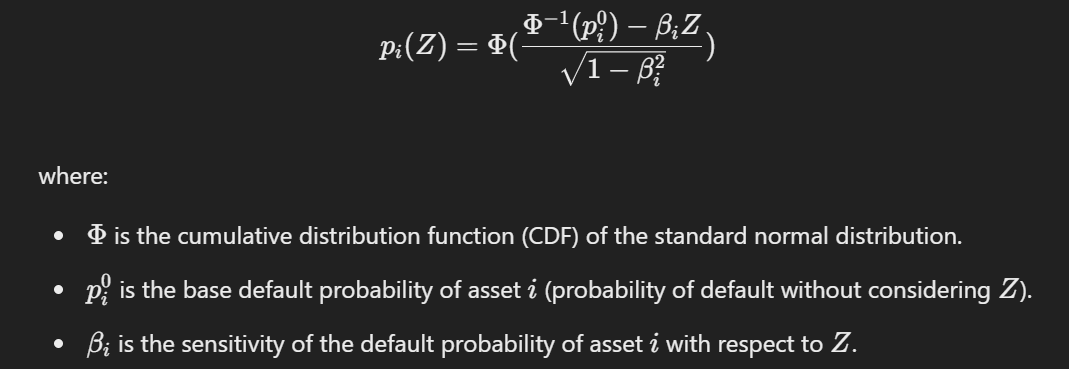

Lets try out a simple example for this. Lets say I am an investor and I have an asset A. The base default probability is 5% i.e. the probability of default without considering the occurence of Z events. Z is lets say an event that affects all of my assets in the portfolio (like suppose a stock market crash due to Covid-19) The sensitivity of default with respect to event Z is beta which is 0.3. If Z is high economic condition can be said to be good and bad otherwise. Beta is the sensitivity that how much likely would I be for default due to a Z crash happening. If Z=0.1 the default probability is calculated by plugging into the formula.


---

Now we'll see some risk measures to assess our portfolio.
* Total Loss=ΣLi.Xi. Where Li is the loss
if asset i defaults and Xi is a bernoulli variable (represents whether asset defaults or not, 1 is default 0 if not)
* Value at Risk (VaR) is a widely used measure for credit risk assessment of a portfolio. VaR at a confidence level a is the maximum loss that won't be exceeded with probability a. It tells you how much you could lose until a particular threshold. Suppose VaR of my portfolio today is 1M at a=95% then it implies: There's a 95% chance that portfolio won't lose more than 1M  in a single day or There's a 5% chance of the portfolio losing 1M  in 1 day.


---


Conditional Value at Risk (CVaR): It
provides expected loss beyond the VaR threshold. In the previous example for the same VaR if CVaR is 1.2M then it implies that if losses exceed 1M  then the expected loss on an average will be 1.2M


In [3]:
n_z = 2 #Number of qubits to represent Z
z_max = 2 #max value of Z
z_values = np.linspace(-z_max, z_max, 2**n_z) #the normally distributed variable
p_zeros = [0.15, 0.25] #base defualt probabilites
rhos = [0.1, 0.05] #sensitivies of base probabilities
lgd = [1, 2] #legend
K = len(p_zeros) #total number of assets defined with initial values of all assets at 0
alpha = 0.05 #confidence level for VaR and CVaR

The goal is to construct a quantum circuit that models the uncertainty in the default probabilities of a portfolio of assets using qubits. This involves creating a quantum state that represents a standard normal distribution and using this state to control qubits that represent the default events of individual assets.



---

We create a register of n cubits representing Z to encode Z values. We also need a register of assets in the portfolio. Each cubit corresponds to asset being defaulted or not (1 & 0)

---

The quantum state of the first register (representing Z) is used to control Y-rotations on the qubits in the second register (with assets' qubits). These rotations correspond to the default probabilities of the assets, given the value of Z.
A Y-rotation on a qubit changes its state based on the angle of rotation. The rotation angle is related to the probability of the asset defaulting.


---

But what is a Y rotation?

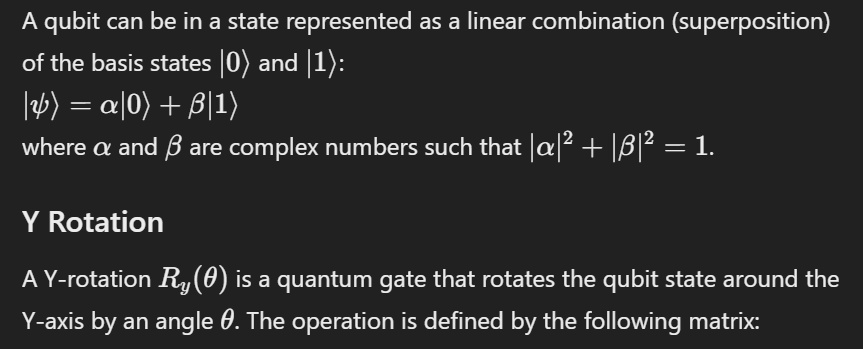

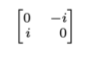

You can learn more in this wikipedia page about quantum circuits: https://en.wikipedia.org/wiki/Quantum_logic_gate


In the above problem the resulting quantum state becomes: 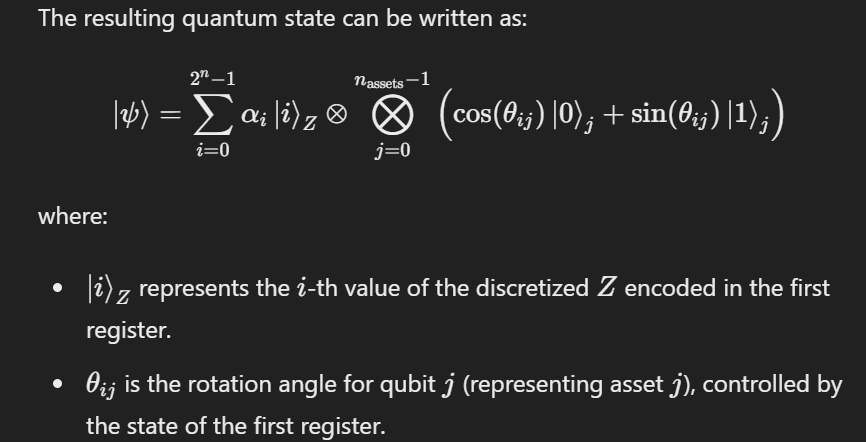

Now lets simulate the circuit and get the values of expected loss, PDF and CDF of L, VaR and CVaR for the uncertainity model used

In [4]:
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

In [14]:
x = GCI(n_z, z_max, p_zeros, rhos)
x.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘

C:\Users\asus\AppData\Local\Temp\ipykernel_12788\2087447710.py:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')
C:\Users\asus\AppData\Local\Temp\ipykernel_12788\2087447710.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(x, backend, shots=1000).result()


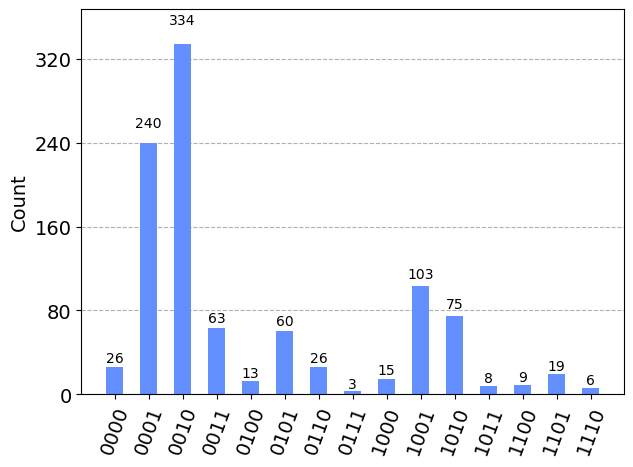

In [6]:
x.measure_all()

backend = Aer.get_backend('qasm_simulator')
x_compiled = transpile(x, backend)
qobj = assemble(x_compiled)
results = execute(x, backend, shots=1000).result()
counts = results.get_counts()

plot_histogram(counts)

C:\Users\asus\AppData\Local\Temp\ipykernel_12788\217646756.py:5: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(binary_probabilities)


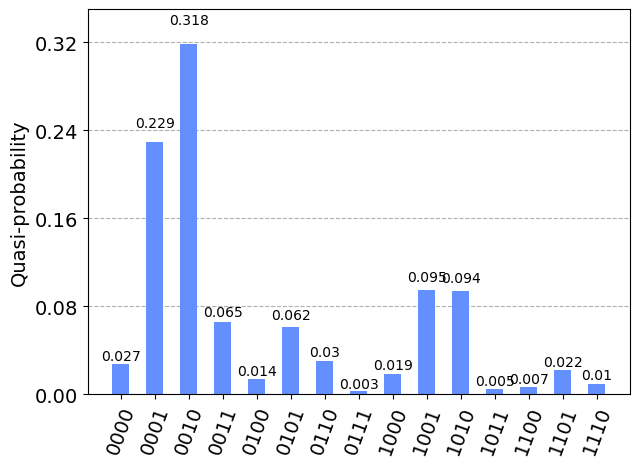

In [15]:
u_measure = x.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(u_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(binary_probabilities)

In [9]:
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = x.num_qubits

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]


values = np.array(values)
probabilities = np.array(probabilities)

expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

In [10]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                0.6416
Value at Risk VaR[L]:              2.0000
P[L <= VaR[L]]:                    0.9609
Conditional Value at Risk CVaR[L]: 3.0000


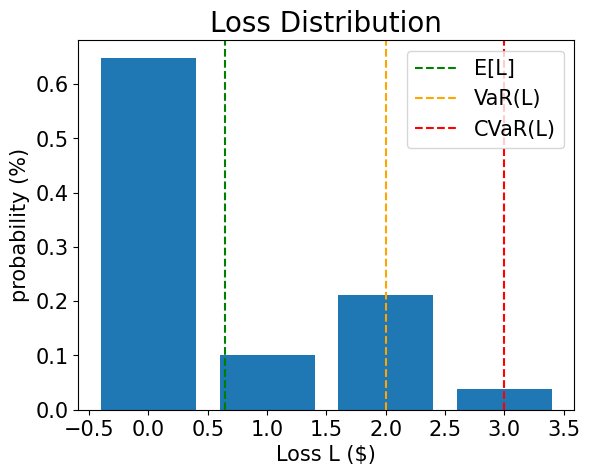

In [11]:
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

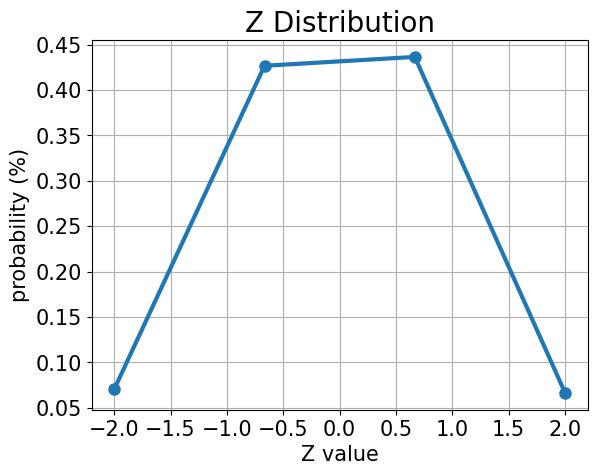

In [12]:
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

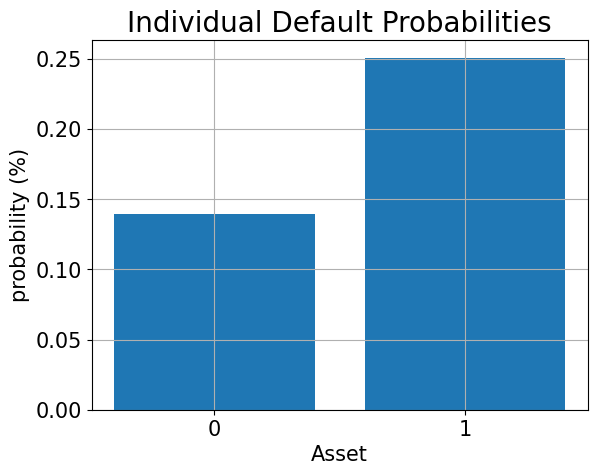

In [13]:
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()